In [1]:
import SimpleITK as sitk
import os

##### Import the DICOM

In [2]:
base_dir = "../../project_n/data/Original_Data_in_DICOM_Format/"
classes = ["positive", "negative"]

patient_paths = []
patient_slices = []

for cls in classes:
    cls_dir = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_dir):
        continue

    for patient_id in sorted(os.listdir(cls_dir)):
        patient_dir = os.path.join(cls_dir, patient_id)
        if not os.path.isdir(patient_dir):
            continue

        slices = sorted(
            [f for f in os.listdir(patient_dir) if os.path.isfile(os.path.join(patient_dir, f))]
        )
        if not slices:
            continue

        patient_paths.append(patient_dir)
        patient_slices.append(slices)

print(f"Loaded {len(patient_slices)} Patients")
print(f"Loaded {sum(len(slices) for slices in patient_slices)} DICOM file slices")
print("--------------------------------------------------")
for path, slices in zip(patient_paths, patient_slices):
    print(f"Patient {path} has {len(slices)} slices.")

Loaded 167 Patients
Loaded 27356 DICOM file slices
--------------------------------------------------
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF002 has 57 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF004 has 171 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF006 has 151 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF007 has 146 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF008 has 130 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF009 has 98 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF010 has 138 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF011 has 111 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF012 has 146 slices.
Patient ../../project_n/data/Original_Data_in_DICOM_Format/positive/UF013 has 152 slices.


In [3]:
reader = sitk.ImageFileReader()

angle_information = dict()

patients = ["UF066"]

for i, p_s in enumerate(zip(patient_paths, patient_slices)):
    path, slices = p_s
    if os.path.basename(os.path.normpath(path)) not in patients:
        continue
    print(f"Processing patient {i} ({i+1}/{len(patient_paths)})")
    patient_id = os.path.basename(os.path.normpath(path))
    for filename in slices:
        filepath = os.path.join(path, filename)
        try:
            reader.SetFileName(filepath)
            reader.ReadImageInformation()
            angle = reader.GetOrigin()[2]
        except Exception:
            continue

        if patient_id not in angle_information:
            angle_information[patient_id] = dict()
        angle_information[patient_id][filepath] = angle

# Print min/max per patient
for patient_id in sorted(angle_information.keys()):
    angles = list(angle_information[patient_id].values())
    if not angles:
        continue
    print(f"Patient {patient_id} Min: {min(angles)}, Max: {max(angles)}")

# Sort angles by degree within each patient
for patient_id in angle_information.keys():
    angle_information[patient_id] = sorted(angle_information[patient_id].items(), key=lambda x: x[1])

Processing patient 36 (37/167)
Patient UF066 Min: -45.784402371853, Max: 88.1604744222156


Now I want to analyze the differences between the angles per slices

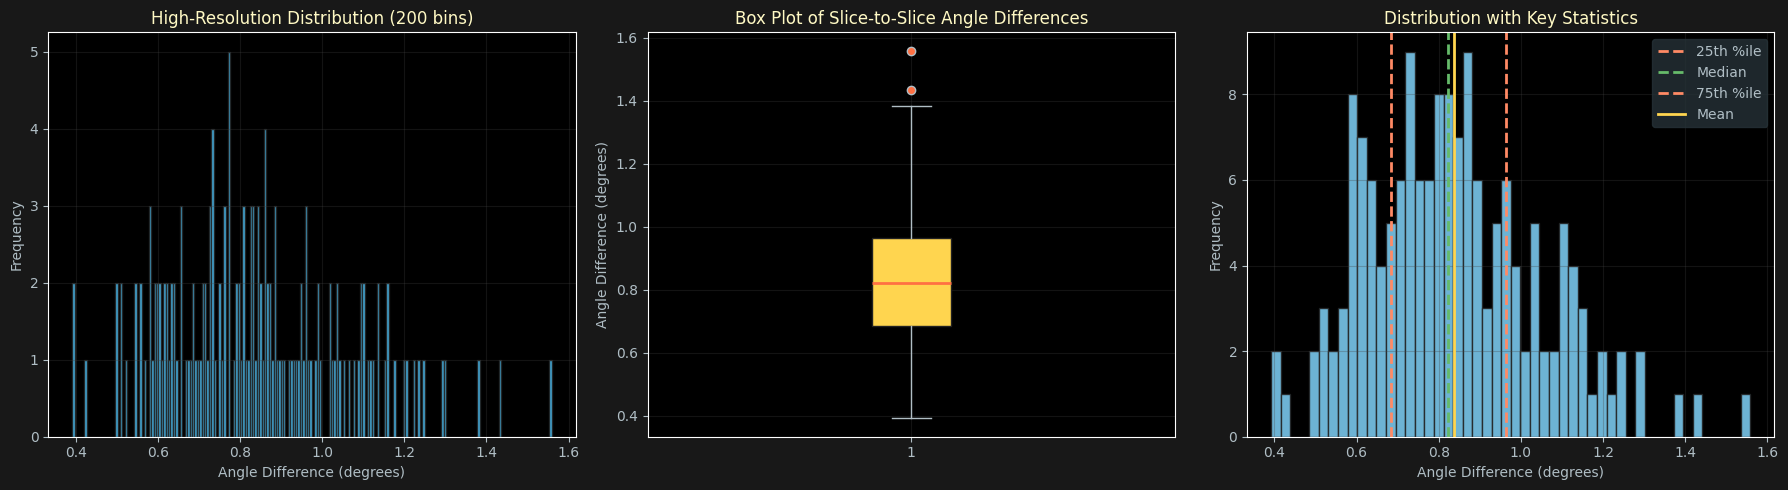


SLICE-TO-SLICE ANGLE DIFFERENCES STATISTICS

Basic Statistics:
--------------------
      Mean:   0.8372°
    Median:   0.8223°
   Std Dev:   0.2140°
       Min:   0.3916°
       Max:   1.5588°

Percentile Distribution:
-------------------------
  1th %ile:   0.4096°
  5th %ile:   0.5442°
 10th %ile:   0.5885°
 25th %ile:   0.6834°
 50th %ile:   0.8223°
 75th %ile:   0.9645°
 90th %ile:   1.1258°
 95th %ile:   1.2091°
 99th %ile:   1.4031°

Total samples: 160


In [4]:
import numpy as np
import matplotlib.pyplot as plt

differences = []
patients_with_differences_greater_than_x = set()
high_difference_context = []

number_greater_than_x = 0
number_differences = 0
x = 1
context_radius = 2  # how many neighbouring pairs to keep on each side

for patient_id, pairs in angle_information.items():
    if not pairs:
        continue

    previous_angle = None
    previous_angle_idk = None

    for idx, (idk, angle) in enumerate(pairs):
        if previous_angle is None:
            previous_angle = angle
            previous_angle_idk = idk
            continue

        diff = abs(previous_angle - angle)
        differences.append(diff)
        number_differences += 1

        if diff > x:
            number_greater_than_x += 1
            patients_with_differences_greater_than_x.add(patient_id)

            start = max(idx - context_radius, 0)
            stop = min(idx + context_radius + 1, len(pairs))
            high_difference_context.append({
                "patient_id": patient_id,
                "prev_idk": previous_angle_idk,
                "curr_idk": idk,
                "prev_angle": previous_angle,
                "curr_angle": angle,
                "difference": diff,
                "slice_indices": list(range(start, stop)),
                "slice_pairs": pairs[start:stop],
            })

        previous_angle = angle
        previous_angle_idk = idk


# Create a comprehensive visualization with three plots in dark mode

# Set dark background for matplotlib
plt.style.use('dark_background')

# Custom colors for dark mode
hist_color1 = '#4FC3F7'  # light blue
hist_color2 = '#81D4FA'  # sky blue
box_color = '#FFD54F'    # yellow
edge_color = '#212121'   # dark gray for edges
grid_color = '#424242'   # grid color
title_color = '#FFF9C4'  # light yellow
label_color = '#B0BEC5'  # light gray

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), facecolor='#181818')
fig.patch.set_facecolor('#181818')

# First plot: 200-bin histogram (as requested)
ax1.hist(differences, bins=200, alpha=0.85, color=hist_color1, edgecolor=edge_color)
ax1.set_xlabel('Angle Difference (degrees)', color=label_color)
ax1.set_ylabel('Frequency', color=label_color)
ax1.set_title('High-Resolution Distribution (200 bins)', color=title_color)
ax1.grid(True, alpha=0.3, color=grid_color)
ax1.tick_params(colors=label_color)

# Second plot: Box plot
box = ax2.boxplot(differences, vert=True, patch_artist=True,
                  boxprops=dict(facecolor=box_color, color=edge_color),
                  medianprops=dict(color='#FF7043', linewidth=2),
                  whiskerprops=dict(color=label_color),
                  capprops=dict(color=label_color),
                  flierprops=dict(markerfacecolor='#FF7043', markeredgecolor=label_color))
ax2.set_ylabel('Angle Difference (degrees)', color=label_color)
ax2.set_title('Box Plot of Slice-to-Slice Angle Differences', color=title_color)
ax2.grid(True, alpha=0.3, color=grid_color)
ax2.tick_params(colors=label_color)

# Third plot: Histogram with percentile lines
ax3.hist(differences, bins=50, alpha=0.85, color=hist_color2, edgecolor=edge_color)
ax3.axvline(np.percentile(differences, 25), color='#FF8A65', linestyle='--', label='25th %ile', linewidth=2)
ax3.axvline(np.percentile(differences, 50), color='#66BB6A', linestyle='--', label='Median', linewidth=2)
ax3.axvline(np.percentile(differences, 75), color='#FF8A65', linestyle='--', label='75th %ile', linewidth=2)
ax3.axvline(np.mean(differences), color='#FFD54F', linestyle='-', linewidth=2, label='Mean')
ax3.set_xlabel('Angle Difference (degrees)', color=label_color)
ax3.set_ylabel('Frequency', color=label_color)
ax3.set_title('Distribution with Key Statistics', color=title_color)
ax3.legend(facecolor='#263238', edgecolor='#263238', labelcolor=label_color)
ax3.grid(True, alpha=0.3, color=grid_color)
ax3.tick_params(colors=label_color)

plt.tight_layout()
plt.show()

# Display statistics in a nice formatted table (console output remains unchanged)
print("\n" + "="*50)
print("SLICE-TO-SLICE ANGLE DIFFERENCES STATISTICS")
print("="*50)

# Basic statistics
stats = {
    'Mean': np.mean(differences),
    'Median': np.median(differences),
    'Std Dev': np.std(differences),
    'Min': np.min(differences),
    'Max': np.max(differences)
}

print("\nBasic Statistics:")
print("-" * 20)
for stat, value in stats.items():
    print(f"{stat:>10}: {value:8.4f}°")

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nPercentile Distribution:")
print("-" * 25)
for p in percentiles:
    value = np.percentile(differences, p)
    print(f"{p:>3}th %ile: {value:8.4f}°")

print("\n" + "="*50)
print(f"Total samples: {len(differences):,}")
print("="*50)


In [5]:
high_difference_context

[{'patient_id': 'UF066',
  'prev_idk': '../../project_n/data/Original_Data_in_DICOM_Format/positive/UF066/US284.dcm',
  'curr_idk': '../../project_n/data/Original_Data_in_DICOM_Format/positive/UF066/US283.dcm',
  'prev_angle': -45.163026548319,
  'curr_angle': -43.913554390665,
  'difference': 1.2494721576540044,
  'slice_indices': [0, 1, 2, 3, 4],
  'slice_pairs': [('../../project_n/data/Original_Data_in_DICOM_Format/positive/UF066/US285.dcm',
    -45.784402371853),
   ('../../project_n/data/Original_Data_in_DICOM_Format/positive/UF066/US284.dcm',
    -45.163026548319),
   ('../../project_n/data/Original_Data_in_DICOM_Format/positive/UF066/US283.dcm',
    -43.913554390665),
   ('../../project_n/data/Original_Data_in_DICOM_Format/positive/UF066/US282.dcm',
    -42.794062300374),
   ('../../project_n/data/Original_Data_in_DICOM_Format/positive/UF066/US281.dcm',
    -41.83066088308)]},
 {'patient_id': 'UF066',
  'prev_idk': '../../project_n/data/Original_Data_in_DICOM_Format/positive/UF0

In [ ]:
import numpy as np

def save_patch_as_volume(input_npz_path: str, output_npz_path: str) -> None:
    """
    Load a patch produced by data_build.py (keys: 'slices', 'angles', ...)
    and save only the stacked slices as a 3D volume (ignores angles).

    - input_npz_path: path to an existing patch .npz (from data_build.py)
    - output_npz_path: path to write a new .npz containing 'volume'
    """
    with np.load(input_npz_path, allow_pickle=False) as data:
        if "slices" not in data:
            raise ValueError("Input NPZ missing 'slices' array.")
        slices = data["slices"]  # shape: (num_slices, H, W), dtype float32
    volume = np.asarray(slices, dtype=np.float32)
    np.savez(output_npz_path, volume=volume)

In [36]:
import SimpleITK as sitk
from reconstruction import extract_slices
import matplotlib.pyplot as plt
import numpy as np

slices = extract_slices("data/Original_Data_in_DICOM_Format/positive/UF029")
# slices = extract_slices("data/Original_Data_in_DICOM_Format/negative/UF003")
# slices = extract_slices("data/Original_Data_in_DICOM_Format/positive/UF066")

Top: 1, Bot: 0, Left: 103, Right: 103


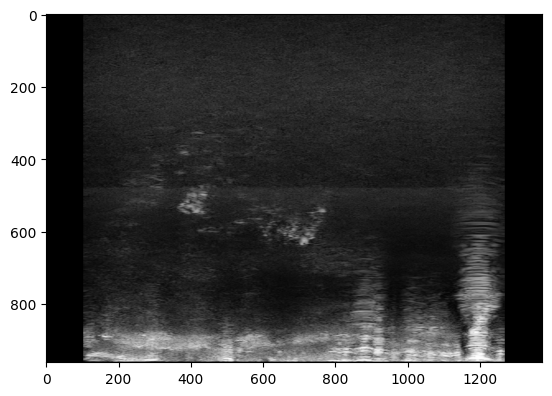

In [ ]:
for slice in slices:
    top = 0
    is_top = True
    bot = 0
    left = 0
    is_left = True
    right = 0
    slice_volume = slices[slice]["slice_volume"]
    for row in slice_volume:
        if np.sum(row) == 0 and is_top:
            bot += 1
        if np.sum(row) > 0:
            is_top = False
        if np.sum(row) == 0 and not is_top:
            top += 1
    for col in slice_volume.T: 
        if np.sum(col) == 0 and is_left:
            right += 1
        if np.sum(col) > 0:
            is_left = False
        if np.sum(col) == 0 and not is_left:
            left += 1
    print(f"Top: {top}, Bot: {bot}, Left: {left}, Right: {right}")
    plt.imshow(slices[slice]["slice_volume"], cmap="gray")
    plt.show()
    break
    # i += 1
    # if i > 10:
    #     break


In [5]:
import numpy as np

data_test_path = "/home/chojnowski.h/weishao/chojnowski.h/project_s/data/datasets/data_1.8/negative_UF003/patch_001.npz"

with np.load(data_test_path, allow_pickle=False) as f:
    print(f["slices"].shape)
    print(f["angle"])
    print(f["angles"])

(3, 962, 1372)
0.31622416
[-71.8574  -71.72419 -71.43615]


In [ ]:
dif